# Elephants Flows - Online inference in dataplane

This notebook focuses on training an algorithm for flow classification, accuracy evaluation, and export for use in the data plane of a network.

The original traffic trazes can be found [here](https://pages.cs.wisc.edu/~tbenson/IMC10_Data.html). We create the [datasetGenerator.py](https://github.com/davidcamilo0710/Elephant_flows/blob/master/scripts/datasetGenerator.py) script to extract all the flows, the 5 tuples and the weight of the first 7 packets.

# INDEX

## [Data Pre-processing](#data)

## [Modeling](#modeling)
  * [Training and Test data](#trainig)
  * [Classification Algorithm](#clasification)
  * [Predictions and accuracy](#accuracy)
  * [Export the trained model](#sav)

In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pickle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('once')

<a id="data"></a>
# Data Preprocessing
The dataset is imported specifying its directory, also the algorithm (decision tree or random forest) and the weight to balance the training.

In [105]:
algoritmo = "DT"
directorio = "../datasets/UNI1.csv"
w = 10

dataset1 = pd.read_csv(r''+directorio+'')

# Import dataset
dataset1['Elephant'] = np.where(dataset1.tot_size > 100000, 1, 0)
drop_elements = ["tot_size"]
X = dataset1.drop(drop_elements, axis=1)
Num = dataset1.groupby('Elephant').size()

print(X.dtypes)
X.shape

ip_proto     float64
port_src     float64
port_dst     float64
size_pkt1    float64
size_pkt2    float64
size_pkt3    float64
size_pkt4    float64
size_pkt5    float64
size_pkt6    float64
size_pkt7    float64
Elephant       int32
dtype: object


(72690, 11)

Let's look at the characteristics and their importance when predicting a flow.

In [106]:
data_train = X.drop(columns = 'Elephant')
feature_list = list(data_train.columns)

# Get numerical feature importances
importances = list(modelo.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: size_pkt6            Importance: 0.3
Variable: size_pkt3            Importance: 0.25
Variable: size_pkt7            Importance: 0.12
Variable: size_pkt4            Importance: 0.09
Variable: size_pkt5            Importance: 0.09
Variable: port_dst             Importance: 0.05
Variable: size_pkt2            Importance: 0.05
Variable: port_src             Importance: 0.02
Variable: size_pkt1            Importance: 0.02
Variable: ip_proto             Importance: 0.0


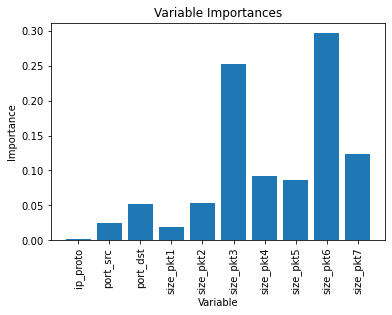

In [107]:
# list of x locations for plotting and Make a bar chart
x_values = list(range(len(importances)))
plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation='vertical')

# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

<a id="modeling"></a>
# Modeling

<a id="trainig"></a>
## Training and Test data
Separate the ones and zeros to compare the predictions separately and calculate the FPR and TPR.

In [108]:
data0 = X[X['Elephant'] == 0]
data1 = X[X['Elephant'] == 1]
data0.head(5)

,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,Elephant
571,6.0,43750.0,80.0,62.0,60.0,690.0,60.0,60.0,60.0,60.0,0
580,6.0,60823.0,80.0,62.0,60.0,587.0,66.0,60.0,60.0,60.0,0
581,6.0,2250.0,80.0,62.0,60.0,1055.0,60.0,60.0,60.0,60.0,0
583,6.0,29261.0,80.0,62.0,60.0,538.0,60.0,60.0,60.0,60.0,0
588,6.0,11211.0,80.0,62.0,60.0,1035.0,60.0,60.0,60.0,60.0,0


In [109]:
data1.head(5)

,ip_proto,port_src,port_dst,size_pkt1,size_pkt2,size_pkt3,size_pkt4,size_pkt5,size_pkt6,size_pkt7,Elephant
0,6.0,22.0,59984.0,130.0,1434.0,90.0,146.0,130.0,146.0,146.0,1
1,6.0,59984.0,22.0,162.0,66.0,130.0,66.0,130.0,66.0,130.0,1
2,6.0,80.0,15636.0,66.0,60.0,436.0,1446.0,1446.0,1366.0,60.0,1
3,17.0,443.0,1687.0,135.0,247.0,295.0,247.0,295.0,247.0,295.0,1
4,6.0,445.0,1803.0,158.0,214.0,158.0,214.0,158.0,214.0,158.0,1


Separate the training and test data.

In [110]:
dataT0 = data0.drop(columns = 'Elephant')
datat0 = data0["Elephant"]
dataT1 = data1.drop(columns = 'Elephant')
datat1 = data1["Elephant"]

# We separate the ones and zeros to be able to compare the predictions separately
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns = 'Elephant'), X['Elephant'], random_state = 0)

<a id="clasification"></a>
## Classification Algorithm
Create the classification model with decision tree and random forest. The tree depth, the number of trees, the weight and other parameters are configured and calibrated for best performance.

In [111]:
if algoritmo == "RF":
    # Create the model
    modelo = RandomForestClassifier(
            n_estimators      = 5,
            max_depth         = 14,
            n_jobs            = 2,
            min_samples_leaf = 9,
            max_leaf_nodes = 200,
            class_weight={1:w})
    
elif(algoritmo == "DT"):
    modelo = DecisionTreeClassifier(
                max_depth         = 14,
                min_samples_leaf = 9,
                max_leaf_nodes = 200,
                class_weight={1:w})
    
else:
    print("Only DT (Desicion Tree) or RF (Randon Forest)")
    
modelo.fit(X_train, y_train)

DecisionTreeClassifier(class_weight={1: 10}, max_depth=14, max_leaf_nodes=200,
                       min_samples_leaf=9)

<a id="accuracy"></a>
## Predictions and accuracy
Make the inference for the elephants and mice separately.

In [112]:
predicciones = modelo.predict(X_test) # Total Prediction
pre0 = modelo.predict(dataT0) # Prediction of 0
pre1 = modelo.predict(dataT1) # Prediction of 1

Calculates and prints the TPR, FPR and MCC

In [113]:
mcc=matthews_corrcoef(y_test, predicciones)

accurac1 = accuracy_score(  y_true    = datat1,
                            y_pred    = pre1,
                            normalize = True )
    
accurac0 = accuracy_score(
                            y_true    = datat0,
                            y_pred    = pre0,
                            normalize = True
                            )
# Total
accurac2 = accuracy_score(
                            y_true    = y_test,
                            y_pred    = predicciones,
                            normalize = True
                            )

if algoritmo == "RF":
    print('Random Forest')
elif algoritmo == "DT":
    print('Decision Tree')
print("TPR: {:.2f} %".format(100 * accurac1))
print("FPR: {:.2f} %".format(100 * (1-accurac0)))
print("MCC: {:.2f} \n".format(mcc))

Decision Tree
TPR: 94.23 %
FPR: 31.43 %
MCC: 0.39 



<a id="sav"></a>
## Export the trained Model
Export the tree to make the inference in the simulation (Python) and emulation (P4).

In [115]:
if algoritmo == "RF":
    filename = open('tree_RF.sav', 'wb')
    pickle.dump(modelo, filename)
    filename.close()
elif algoritmo == "DT":
    filename = open('tree_DT.sav', 'wb')
    pickle.dump(modelo, filename)
    filename.close()